In [1]:
import tensorflow as tf
import tflite_runtime.interpreter as tflite
print(tf.__version__)
import IPython
print(IPython.__version__)
import IPython.display as display


import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools
print ("Done")

2021-07-30 18:25:27.044351: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-30 18:25:27.044402: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.7.0-dev20210730
7.25.0
Done


In [2]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

In [3]:
# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

In [10]:
# Load the input images.
content_image = load_img('img/kevin_avant.jpg')
style_image_1 = load_img('style/graf1.jpg')
style_image_2 = load_img('style/graf2.jpg')

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image_1 = preprocess_image(style_image_1, 256)
preprocessed_style_image_2 = preprocess_image(style_image_2, 256)

print('Style Image Shape:', preprocessed_style_image_1.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


In [34]:
hello = tf.constant('Hello, TensorFlow!')
print(hello)

tf.Tensor(b'Hello, TensorFlow!', shape=(), dtype=string)


In [35]:
tf.test.is_gpu_available()

False

In [36]:
tf.config.list_physical_devices('GPU')

[]

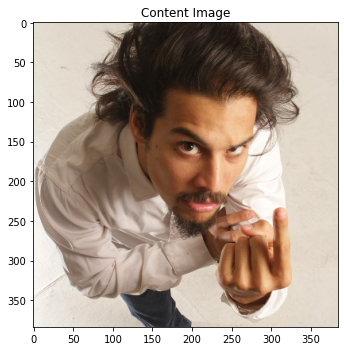

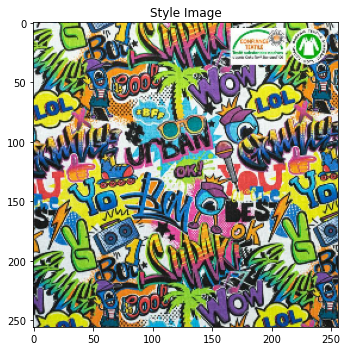

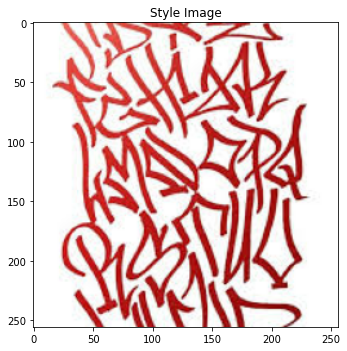

In [11]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
  plt.show()

plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image_1, 'Style Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image_2, 'Style Image')

In [6]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path='models/prediction.tflite')

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck


In [12]:
# Calculate style bottleneck for the preprocessed style image.
style_bottleneck_1 = run_style_predict(preprocessed_style_image_1)
style_bottleneck_2 = run_style_predict(preprocessed_style_image_2)
print('Style Bottleneck Shape:', style_bottleneck_1.shape)

Style Bottleneck Shape: (1, 1, 1, 100)


In [8]:
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path='models/transfer.tflite')

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

In [16]:
stylized_image_1 = run_style_transform(style_bottleneck_1, preprocessed_content_image)


SyntaxError: invalid syntax (2235593866.py, line 2)

In [21]:
print('Style Bottleneck Shape:', stylized_image_1[0].shape)

Style Bottleneck Shape: (384, 384, 3)


In [19]:
print('Style Bottleneck Shape:', type(stylized_image_1))

Style Bottleneck Shape: <class 'numpy.ndarray'>


In [20]:
print(stylized_image_1)

[[[[0.98828125 0.61328125 0.359375  ]
   [0.9765625  0.5859375  0.359375  ]
   [0.97265625 0.52734375 0.359375  ]
   ...
   [0.859375   0.71484375 0.09375   ]
   [0.81640625 0.71484375 0.08203125]
   [0.7578125  0.734375   0.08203125]]

  [[0.9921875  0.796875   0.5       ]
   [0.984375   0.61328125 0.4140625 ]
   [0.97265625 0.52734375 0.47265625]
   ...
   [0.88671875 0.71484375 0.09375   ]
   [0.84765625 0.71484375 0.08203125]
   [0.796875   0.734375   0.08203125]]

  [[0.984375   0.734375   0.52734375]
   [0.88671875 0.3125     0.18359375]
   [0.796875   0.18359375 0.22265625]
   ...
   [0.859375   0.640625   0.0625    ]
   [0.81640625 0.6640625  0.05078125]
   [0.7578125  0.6640625  0.05078125]]

  ...

  [[0.52734375 0.3125     0.1015625 ]
   [0.7578125  0.6640625  0.359375  ]
   [0.3359375  0.359375   0.07421875]
   ...
   [0.83203125 0.52734375 0.3125    ]
   [0.6640625  0.47265625 0.265625  ]
   [0.55859375 0.6640625  0.28515625]]

  [[0.18359375 0.15234375 0.11328125]
   [0.3

In [14]:
# Stylize the content image using the style bottleneck.
stylized_image_1 = run_style_transform(style_bottleneck_1, preprocessed_content_image)
stylized_image_2 = run_style_transform(style_bottleneck_2, preprocessed_content_image)

tf.keras.preprocessing.image.save_img('test.jpg', stylized_image_1[0])

# Visualize the output.
imshow(stylized_image_1, 'Stylized Image 1')
imshow(stylized_image_2, 'Stylized Image 2')

ValueError: Expected image array to have rank 3 (single image). Got array with shape: (1, 384, 384, 3)

In [24]:
tf.keras.preprocessing.image.save_img('outputs/test2.jpg', stylized_image_1[0])